In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import torchvision
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Subset
import numpy as np
import matplotlib.pyplot as plt
import random
from torch import nn
import torch.optim as optim
import seaborn as sns
import pandas as pd

batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = np.array([0.485, 0.456, 0.406]) # imagenet standards
std = np.array([0.229, 0.224, 0.225]) # imagenet standards

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((150,150)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean,std)])

full_path = '/content/drive/My Drive/Colab Notebooks/brain_tumor_datasets/equally_splitted_DCGAN/'

train_path = full_path+'Training/'
validate_path = full_path+'Validation/'  
test_path = full_path+'Testing/'

trainset = torchvision.datasets.ImageFolder(train_path, transform=transform)
validateset = torchvision.datasets.ImageFolder(validate_path, transform=transform)
testset = torchvision.datasets.ImageFolder(test_path, transform=transform)

print("Train set size = ", len(trainset),
     "\nValidate set size = ", len(validateset),
     "\nTest set size = ", len(testset))

Train set size =  2520 
Validate set size =  360 
Test set size =  720


In [ ]:
# dataloaders
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validate_dataloader = torch.utils.data.DataLoader(validateset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

loaders = {'train': train_dataloader, 'valid': validate_dataloader, 'test': test_dataloader}

In [ ]:
class_names = trainset.classes
number_classes = len(class_names)
print(number_classes, ' classes: ', class_names)

4  classes:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


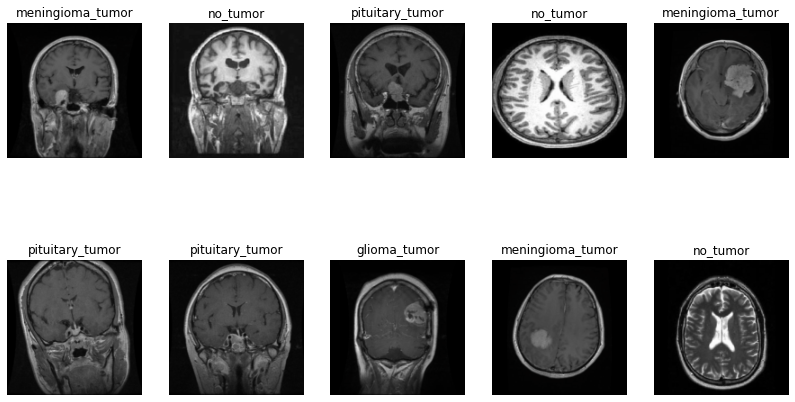

In [ ]:

def remove_normlization(figure, std, mean):
    return figure * std[:, None, None] + mean[:, None, None]

fig = plt.figure(figsize=(14,8))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    random_img = random.randint(0, len(trainset))
    # unnormalize the image
    image = remove_normlization(trainset[random_img][0], torch.Tensor(std), torch.Tensor(mean)) 
    # convert it from tensor to image
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title(class_names[trainset[random_img][1]])
    plt.axis('off')
plt.show()

In [ ]:
# loss function + optimizer
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    #select and return optimizer
    return optim.Adam(model.parameters(),lr = 0.0001)


In [ ]:
from torchvision import models

model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers (to stop feature training)
for parameter in model_transfer.features.parameters():
    parameter.requires_grad = False
    
# replace the final layer with our number of classes
n_input = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(n_input, number_classes) # number_classes = 4

In [ ]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
training_loss = []
validation_loss = []

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    model.cuda()
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))           
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        training_loss.append(train_loss)
        validation_loss.append(valid_loss)

        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.4f} --> {:.4f}), model saved'.format(valid_loss_min,
                                                                                            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    confusion_matrix = np.zeros((number_classes, number_classes))

    model.cuda()
    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    # confusion matrix
    plt.figure(figsize=(15,10))

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

In [ ]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
train(20, loaders, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
      use_cuda, full_path+'model_transfer.pt')

Epoch: 1 	Training Loss: 0.358853 	Validation Loss: 1.211713
Validation loss decreased (inf --> 1.2117), model saved
Epoch: 2 	Training Loss: 0.225600 	Validation Loss: 1.402592
Epoch: 3 	Training Loss: 0.132079 	Validation Loss: 1.706222
Epoch: 4 	Training Loss: 0.092752 	Validation Loss: 2.423388
Epoch: 5 	Training Loss: 0.083723 	Validation Loss: 1.755512
Epoch: 6 	Training Loss: 0.050547 	Validation Loss: 1.869569
Epoch: 7 	Training Loss: 0.024800 	Validation Loss: 2.041594
Epoch: 8 	Training Loss: 0.024118 	Validation Loss: 2.022746
Epoch: 9 	Training Loss: 0.015591 	Validation Loss: 2.148668
Epoch: 10 	Training Loss: 0.012967 	Validation Loss: 2.319714
Epoch: 11 	Training Loss: 0.010632 	Validation Loss: 2.936857
Epoch: 12 	Training Loss: 0.008689 	Validation Loss: 2.509103
Epoch: 13 	Training Loss: 0.012560 	Validation Loss: 2.330409
Epoch: 14 	Training Loss: 0.007512 	Validation Loss: 2.764508
Epoch: 15 	Training Loss: 0.007115 	Validation Loss: 2.910780
Epoch: 16 	Training Los

<All keys matched successfully>

Test Loss: 0.901004


Test Accuracy: 66% (480/720)


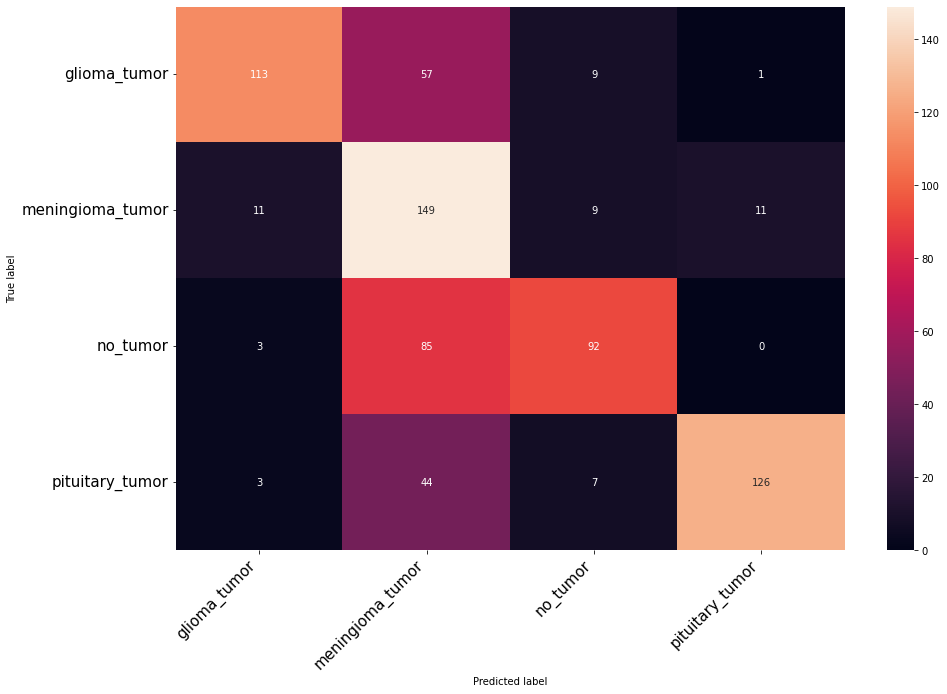

In [ ]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load(full_path+'model_transfer.pt'))

test(loaders, model_transfer, criterion_transfer, use_cuda)

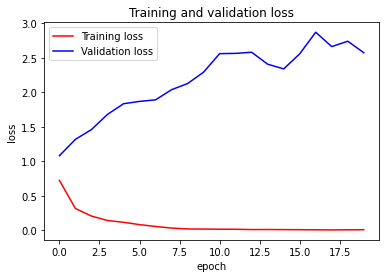

In [ ]:
# Plotting the training and validation loss
loss = training_loss 
val_loss = validation_loss
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

___________________